# ggF 400 GeV $p_T$ cut

**Motivation:** If we use the PC SF, we'll have to place a *cut* on our anlaysis for the jets with $p_T$ > 400 GeV... and we need to know the A: *Does this hurt the ggF anlaysis*???

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from glob import glob 

import matplotlib.pyplot as plt
from matplotlib import gridspec

import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray

import os
os.sys.path += ['../RRevolution/code/','../code',"../PAG-opt/","../PyATLASstyle/"]
from analysis import getXhh
from utils import fileDirSLAC as fileDir, mcToYr
from eventDisplays import rainbow_text

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
from utils import L

**Plan:** Load in the *signal* files for all of the year, and then we can just *make a few plots*!!

In [3]:
x1,y1 = 124,117

In [4]:
pt_cols = ['pT_h1_j1','pT_h1_j2','pT_h2_j1','pT_h2_j2']


cols=['m_hh','ntag','dEta_hh']+pt_cols


In [5]:
fDir = '/u/ki/nhartman/gpfs/diHiggs4b/data/RR/nom_trigs_unblind/ntag_4b'
rwTag = f'_min_dR_VEC_sr_{x1}_{y1}_NN_100_bootstraps'

tName = 'sig'


f16 = uproot.open(f'{fDir}/data16{rwTag}.root')
b16 = f16[tName].pandas.df(cols+['NN_d24_weight_bstrap_med_16'])

f17 = uproot.open(f'{fDir}/data17{rwTag}.root')
b17 = f17[tName].pandas.df(cols+['NN_d24_weight_bstrap_med_17'])

f18 = uproot.open(f'{fDir}/data18{rwTag}.root')
b18 = f18[tName].pandas.df(cols+['NN_d24_weight_bstrap_med_18'])


# Apply the normalization correction to the weights
for yr,bdf,f in zip([16,17,18],[b16,b17,b18],[f16,f17,f18]):
    bdf['w_2b'] = f[f'NN_norm_bstrap_med_{yr}']._fVal * bdf[f'NN_d24_weight_bstrap_med_{yr}']
    bdf['lead_pt'] = np.max(bdf[pt_cols].values,axis=1)
        
# Recall - Sean's already applied the VBF veto
b16 = b16[b16.ntag==2]
b17 = b17[b17.ntag==2]
b18 = b18[b18.ntag==2]

In [6]:
sFile = '../data/RR/NNT_DEC20_MDR_VEC/MC/600043_mc16{}/NanoNTuple.root'

tName = 'fullmassplane'
scols=['pass_vbf_sel','mc_sf','m_h1','m_h2','truth_mhh']

s16 = uproot.open(sFile.format('a'))[tName].pandas.df(cols+scols)
s17 = uproot.open(sFile.format('d'))[tName].pandas.df(cols+scols)
s18 = uproot.open(sFile.format('e'))[tName].pandas.df(cols+scols)

# Apply the lumi uncertainty - and calculate the *new* SR / cut the unwanted events
for yr,sdf in zip([16,17,18],[s16,s17,s18]):
    sdf['mc_sf']     *= L[yr]
    sdf['truth_mhh'] *= 0.001
    
    sdf['Xhh_new'] = getXhh(*sdf[['m_h1','m_h2']].values.T,x1,y1)
    sdf['lead_pt'] = np.max(sdf[pt_cols].values,axis=1)
    
s16 = s16[(s16.Xhh_new < 1.6) & (s16.ntag>=4) & (~s16.pass_vbf_sel)]
s17 = s17[(s17.Xhh_new < 1.6) & (s17.ntag>=4) & (~s17.pass_vbf_sel)]
s18 = s18[(s18.Xhh_new < 1.6) & (s18.ntag>=4) & (~s18.pass_vbf_sel)]

In [7]:
pT_cutoff=400

In [8]:
colors=['darkorange','rebeccapurple','hotpink']

In [9]:
figDir = 'figures/min_dR_srOpt/'

In [10]:
text = "$\mathbf{ATLAS}$ Internal\n"
text += f"min_dR1, X_wt_tag, resonant buckets"

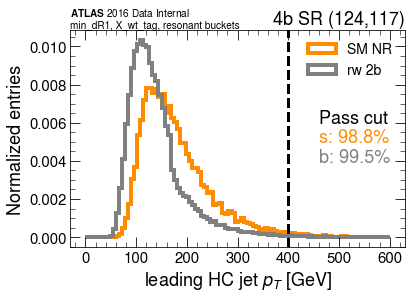

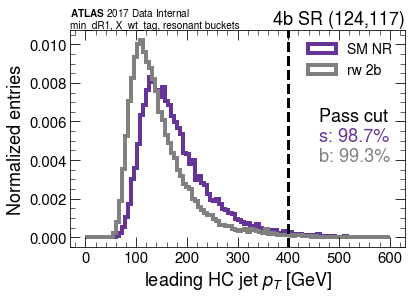

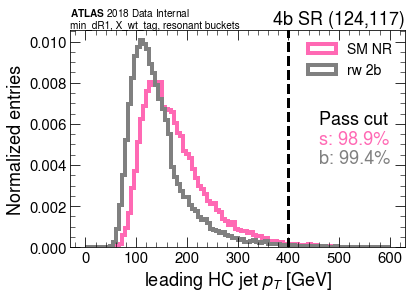

In [11]:
kwargs = {'histtype':'step','lw':4,'density':True}

for sdf,bdf,c,yr in zip([s16,s17,s18],[b16,b17,b18],colors,['16','17','18']):

    plt.figure()
    ls = ['Pass cut']#[f'$p_T$ < {pT_cutoff} GeV']
    lc = ['k',c,'grey']
    for dfi,ci,l,li,w in zip([sdf,bdf],lc[1:],['SM NR','rw 2b'],['s','b'],['mc_sf','w_2b']):
    
        plt.hist(dfi.lead_pt,100,(0,600),color=ci,weights=dfi[w],label=l,**kwargs)

        keep = 100 * np.sum((dfi.lead_pt < pT_cutoff) * dfi[w]) / np.sum(dfi[w])
        ls.append(f'{li}: {keep:.1f}%')
        
        
    plt.legend()
    plt.xlabel('leading HC jet $p_T$ [GeV]',fontsize=18)
    plt.ylabel('Normalized entries',fontsize=18)
    plt.title(f'4b SR ({x1},{y1})',loc='right')

    ylim = plt.ylim()
    plt.plot([pT_cutoff]*2,ylim,'k--')
    plt.ylim(ylim)

    ax=plt.gca()
    rainbow_text(450,.006,ls,lc, yoffset=1.1,ax=ax,fontsize=18)

    ti=text.replace('Int', f'20{yr} Data Int')
    plt.text(0,1,ti,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)
    
    plt.savefig(f'{figDir}/lead_hc_jet_pt_{yr}.pdf',bbox_inches='tight')
    plt.show()

In [12]:
n,r = 40,(200,1200)

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: R

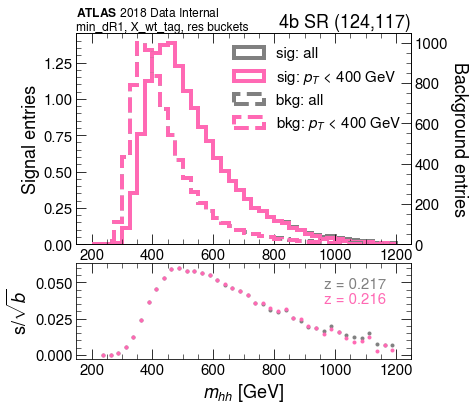

In [63]:
for sdf,bdf,c,yr in zip([s16,s17,s18],[b16,b17,b18],colors,['16','17','18']):

    fig = plt.figure(figsize=(6,6))
    gs = gridspec.GridSpec(3,1)
    ax1 = fig.add_subplot(gs[:2,0])
    ax2 = ax1.twinx()
    ax3 = fig.add_subplot(gs[2,0],sharex=ax1)


    ls = []
    lc=['grey',c]

    for smask, bmask, l, c in zip([np.ones_like(sdf.index).astype(bool), sdf.lead_pt<pT_cutoff],
                                  [np.ones_like(bdf.index).astype(bool), bdf.lead_pt<pT_cutoff],
                                  ['all',f'$p_T$ < {pT_cutoff} GeV'],lc):

        s,e,_ = ax1.hist(sdf.loc[smask,'m_hh'],n,r,histtype='step',color=c,lw=4,
                         label=f'sig: {l}', weights=sdf.loc[smask,'mc_sf'])

        b,_,_ = ax2.hist(bdf.loc[bmask,'m_hh'],n,r, histtype='step',color=c,lw=4,ls='--',
                         label=f'bkg: {l}',weights=bdf.loc[bmask,'w_2b'])

        xx = 0.5 * (e[1:] + e[:-1])
        z = s/np.sqrt(b)

        ax3.plot(xx,z,lw=0,marker='.',color=c)
        zi = np.sqrt(np.sum(z[b!=0]**2))
        ls.append(f'z = {zi:.3f}')
        
    ax3.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
    ax1.set_ylabel('Signal entries',fontsize=18)
    ax2.set_ylabel('Background entries',fontsize=18,rotation=270,labelpad=20)
    ax3.set_ylabel('s$ / \sqrt{b}$',fontsize=18)

    xi = .43
    ax1.legend(loc='upper left', bbox_to_anchor=(xi,1),fontsize=15)
    ax2.legend(loc='upper left', bbox_to_anchor=(xi,.78),fontsize=15)

    ti=text.replace('Int', f'20{yr} Data Int').replace('resonant','res')
    plt.text(0,1,ti,ha='left',va='bottom',transform=ax1.transAxes,fontsize=12)
    ax1.set_title(f'4b SR ({x1},{y1})',loc='right')

    _,ymax = ax3.get_ylim()
    rainbow_text(950,0.85*ymax, ls,lc, yoffset=1.1,ax=ax3,fontsize=15,va='top')

    plt.savefig(f'{figDir}/m_hh_SR_{x1}_{y1}_{yr}.pdf',bbox_inches='tight')

Ok, it seems like the most interesting metric here *really* is the $s/\sqrt{b}$.

In [64]:
kwargs = {'histtype':'step','lw':4,'density':True}
n,r = 40,(200,1200)

ls = ['z(pT cut) / z(all)']
fig,axes = plt.subplots(1,3,figsize=(15,4))

for ax,sdf,bdf,c,yr in zip(axes,[s16,s17,s18],[b16,b17,b18],colors,['16','17','18']):

    zs = []
    
    for smask, bmask, l,ci in zip([np.ones_like(sdf.index).astype(bool), sdf.lead_pt<pT_cutoff],
                                  [np.ones_like(bdf.index).astype(bool), bdf.lead_pt<pT_cutoff],
                                  ['all',f'pT cut'],['grey',c]):#['none','full']):

        s,e = np.histogram(sdf.loc[smask,'m_hh'],n,r,weights=sdf.loc[smask,'mc_sf'])

        b,_ = np.histogram(bdf.loc[bmask,'m_hh'],n,r, weights=bdf.loc[bmask,'w_2b'])

        z = s/np.sqrt(b)
        
        xx = 0.5 * (e[1:] + e[:-1])
        ax.plot(xx,z,lw=1,marker='o',color=ci,#fillstyle=fs,
                 label=f'{l} {yr}')
        zi = np.sqrt(np.sum(z[b!=0]**2))

        zs.append(zi)
        
    ax.text(.18,.1,'$z_{cut}$ / $z_{all}$ = '+f'{zs[1]/zs[0]:.3}',
            transform=ax.transAxes,fontsize=18)
        
    ax.legend(loc='upper right',fontsize=15)
    ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
    
    
axes[0].set_ylabel('s$ / \sqrt{b}$',fontsize=18)

plt.title(f'4b SR ({x1},{y1})',loc='right')
axes[0].text(0,1,text,transform=axes[0].transAxes,fontsize=12,va='bottom' )

plt.savefig(f'{figDir}/sigs_allYrs.pdf',bbox_inches='tight')
plt.show()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: R

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:22: R

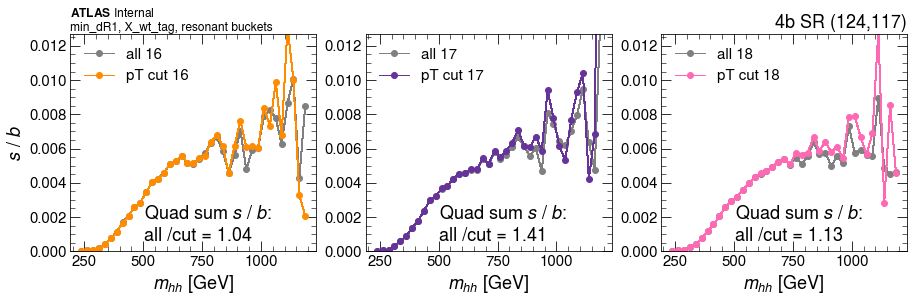

In [70]:
kwargs = {'histtype':'step','lw':4,'density':True}
n,r = 40,(200,1200)

ls = ['z(pT cut) / z(all)']
fig,axes = plt.subplots(1,3,figsize=(15,4))

for ax,sdf,bdf,c,yr in zip(axes,[s16,s17,s18],[b16,b17,b18],colors,['16','17','18']):

    ys = []
    
    for smask, bmask, l,ci in zip([np.ones_like(sdf.index).astype(bool), sdf.lead_pt<pT_cutoff],
                                  [np.ones_like(bdf.index).astype(bool), bdf.lead_pt<pT_cutoff],
                                  ['all',f'pT cut'],['grey',c]):#['none','full']):

        s,e = np.histogram(sdf.loc[smask,'m_hh'],n,r,weights=sdf.loc[smask,'mc_sf'])

        b,_ = np.histogram(bdf.loc[bmask,'m_hh'],n,r, weights=bdf.loc[bmask,'w_2b'])

        y = s/b
        
        xx = 0.5 * (e[1:] + e[:-1])
        ax.plot(xx,s/b,lw=1,marker='o',color=ci,#fillstyle=fs,
                 label=f'{l} {yr}')
        yi = np.sqrt(np.sum(y[b!=0]**2))

        ys.append(yi)
        
    ax.text(.3,.05,'Quad sum $s$ / $b$:\nall /cut = '+f'{ys[1]/ys[0]:.3}',
            transform=ax.transAxes,fontsize=18)
        
    ax.legend(loc='upper left',fontsize=15)
    ax.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
    
    ax.set_ylim(0,.0127)
    
axes[0].set_ylabel('$s$ / $b$',fontsize=18)

plt.title(f'4b SR ({x1},{y1})',loc='right')
axes[0].text(0,1,text,transform=axes[0].transAxes,fontsize=12,va='bottom' )

plt.savefig(f'{figDir}/sOverB_allYrs.pdf',bbox_inches='tight')
plt.show()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:34: R

0.14523436817918794
0.14412706483811022
0.17973647513326052
0.17884741803443596
0.21664525462079834
0.2162313532908917


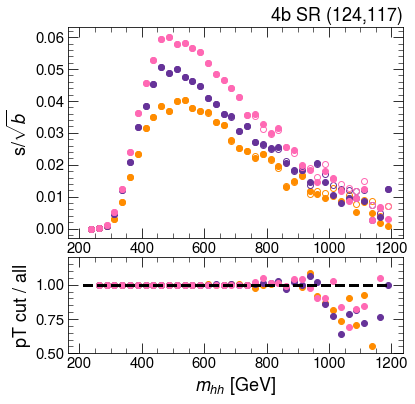

In [68]:
kwargs = {'histtype':'step','lw':4,'density':True}
n,r = 40,(200,1200)

fig = plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2,0],sharex=ax1)


for sdf,bdf,c,yr in zip([s16,s17,s18],[b16,b17,b18],colors,['16','17','18']):


    zs = []
    
    for smask, bmask, l,fs in zip([np.ones_like(sdf.index).astype(bool), sdf.lead_pt<pT_cutoff],
                                  [np.ones_like(bdf.index).astype(bool), bdf.lead_pt<pT_cutoff],
                                  ['all',f'$p_T$ < {pT_cutoff} GeV'],['none','full']):

        s,e = np.histogram(sdf.loc[smask,'m_hh'],n,r,weights=sdf.loc[smask,'mc_sf'])

        b,_ = np.histogram(bdf.loc[bmask,'m_hh'],n,r, weights=bdf.loc[bmask,'w_2b'])

        z = s/np.sqrt(b)
        zs.append(z)
        
        xx = 0.5 * (e[1:] + e[:-1])
        ax1.plot(xx,z,lw=0,marker='o',color=c,fillstyle=fs)
        zi = np.sqrt(np.sum(z[b!=0]**2))
        ls.append(f'z = {zi:.3f}')

        print(zi)

        
    ax2.plot(xx,zs[1]/zs[0],lw=0,marker='o',color=c)
        
ax1.legend(loc='upper right',fontsize=15)
ax2.set_xlabel('$m_{hh}$ [GeV]',fontsize=18)
ax1.set_ylabel('s$ / \sqrt{b}$',fontsize=18)
ax2.set_ylabel('pT cut / all',fontsize=18)

ax1.set_title(f'4b SR ({x1},{y1})',loc='right')
ax2.plot(xx,np.ones_like(xx),'k--')
ax2.set_ylim(0.5,1.2)



plt.show()

In [46]:
.145/.128

1.1328125

In [47]:
.183/.179

1.0223463687150838

Oohhhhhhhh! I should make a $\kappa_\lambda$ scan plot!!

In [48]:
kls = np.arange(-20,21)

In [49]:
kls

array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
        -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
         6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
        19,  20])

In [50]:
from processMNTs import getLambdaWeights

In [51]:
for sdf in [s16,s17,s18]:
    getLambdaWeights(sdf)

In [52]:
sdf.columns

Index(['m_hh', 'ntag', 'dEta_hh', 'pT_h1_j1', 'pT_h1_j2', 'pT_h2_j1',
       'pT_h2_j2', 'pass_vbf_sel', 'mc_sf', 'm_h1', 'm_h2', 'truth_mhh',
       'Xhh_new', 'lead_pt', 'w_k-20', 'w_k-19', 'w_k-18', 'w_k-17', 'w_k-16',
       'w_k-15', 'w_k-14', 'w_k-13', 'w_k-12', 'w_k-11', 'w_k-10', 'w_k-9',
       'w_k-8', 'w_k-7', 'w_k-6', 'w_k-5', 'w_k-4', 'w_k-3', 'w_k-2', 'w_k-1',
       'w_k0', 'w_k2', 'w_k3', 'w_k4', 'w_k5', 'w_k6', 'w_k7', 'w_k8', 'w_k9',
       'w_k10', 'w_k11', 'w_k12', 'w_k13', 'w_k14', 'w_k15', 'w_k16', 'w_k17',
       'w_k18', 'w_k19', 'w_k20'],
      dtype='object')

In [53]:
kept = {k:[] for k in [16,17,18]}

In [54]:
for kl in kls:
    w = 'mc_sf' if kl==1 else f'w_k{kl}'
    
    
    for yr,dfi in zip([16,17,18],[s16,s17,s18]):
    
    
        eff = np.sum((dfi.lead_pt < pT_cutoff) * dfi[w]) / np.sum(dfi[w])
        kept[yr].append(eff)
    

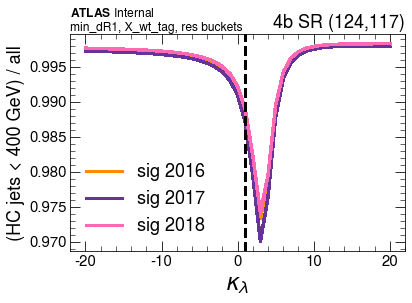

In [56]:
for yr,c in zip([16,17,18],colors):
    plt.plot(kls,kept[yr],c,label=f'sig 20{yr}')
    
plt.xlabel('$\kappa_\lambda$',fontsize=24)
plt.ylabel('(HC jets < 400 GeV) / all',fontsize=18)
plt.legend(fontsize=18)


plt.title(f'4b SR ({x1},{y1})',loc='right')
ax = plt.gca()
plt.text(0,1,text.replace('resonant','res'),transform=ax.transAxes,
         fontsize=12,va='bottom' )

ylim = plt.ylim()
plt.plot([1]*2,ylim,'k--')
plt.ylim(ylim)

plt.savefig(f'{figDir}/kl_yield_SR_{x1}_{y1}_{yr}.pdf',bbox_inches='tight')

Interesting that $\kappa_\lambda$ = 3 loses the *most*... why is this??

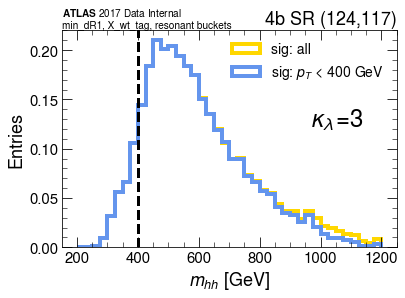

In [57]:
yr=17
sdf=s17
for smask, l, c in zip([np.ones_like(sdf.index).astype(bool), sdf.lead_pt<pT_cutoff],
                       ['all',f'$p_T$ < {pT_cutoff} GeV'],['gold','cornflowerblue']):

    plt.hist(sdf.loc[smask,'m_hh'],n,r,histtype='step',color=c,lw=4,
             label=f'sig: {l}', weights=sdf.loc[smask,'w_k3'])
    
plt.legend()
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Entries',fontsize=18)

ax = plt.gca()
plt.text(.9,.65,f'$\kappa_\lambda$=3',ha='right',va='top',fontsize=24,transform=ax.transAxes)
plt.title(f'4b SR ({x1},{y1})',loc='right')

ylim = plt.ylim()
plt.plot([pT_cutoff]*2,ylim,'k--')
plt.ylim(ylim)


ti=text.replace('Int', f'20{yr} Data Int')
plt.text(0,1,ti,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)

plt.savefig(f'{figDir}/m_hh_kl_3_{yr}.pdf',bbox_inches='tight')
plt.show()

In [58]:
kls[23]

3

In [59]:
kept[17][23]

0.970047464981829

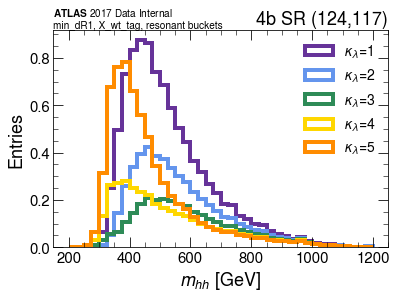

In [60]:
for kl,w, c in zip(range(1,6),['mc_sf','w_k2','w_k3','w_k4','w_k5'],
                  ['rebeccapurple','cornflowerblue','seagreen','gold','darkorange']):


    plt.hist(sdf.loc[smask,'m_hh'],n,r,histtype='step',color=c,lw=4,
             label=f'$\kappa_\lambda$={kl}', weights=sdf.loc[smask,w])

        
plt.legend()
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.title(f'4b SR ({x1},{y1})',loc='right')

ax = plt.gca()
ti=text.replace('Int', f'20{yr} Data Int')
plt.text(0,1,ti,ha='left',va='bottom',transform=ax.transAxes,fontsize=10)

plt.savefig(f'{figDir}/m_hh_kl_1234_{yr}.pdf',bbox_inches='tight')
plt.show()

Some preliminary limits?